In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import glob

### Calibrating the camera

Calibrate the camera based on the calibration images provided in the project (./camera_cal/)

In [2]:
# grab a list of the camera calibration image files
img_list = os.listdir("camera_cal/")

# create a place to hold the average mtx matrix and dist list
mtx_avg = np.zeros((3,3))
dist_avg = np.zeros((1,5))

In [3]:
%matplotlib inline

# function to grab the chessboard corner information from a calibration image. 
# objpoints are for the nx*ny grid
# imgpoints are where the chessboard corners lie in the calibration image pixels
def chessboard_data(img, nx, ny):
    objpoints = []
    imgpoints = []

    # From "Calibrating your camera" section
    objp = np.zeros((ny*nx,3), np.float32)
    objp [:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
    return objpoints, imgpoints

In [4]:
# Learn the camera distortion characteristics based on the input image and knowledge of where
# the chessboard corners lie (objpoints and imgpoints)
# Function comes from "Correcting for Distortion" unit in project's lesson
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:-1], None, None)
    return mtx, dist

In [5]:
# process all of the calibration images
# not all of the calibration images pass through the findChessboardCorners function due to 
# some of the inside corners being out of the image frame
# my code will not error out if the input calibration image doesn't have the grid we expect
# but I need to keep track of how many recognized chessboards have been processed
valid_chessboard_count = 0

# iterate through all of the calibration images
for i in range(len((img_list))):
    print ("Calibrating image %d/%d..." % (i+1, len(img_list)))
    img = cv2.imread('./camera_cal/' + img_list[i])
    orig_img = np.copy(img)
    
    # the number of inside corners in x
    nx = 9 
    # the number of inside corners in y
    ny = 6 

    # extract the chessboard grid and their corresponding mapping to the calibration image pixel
    # space with the chessboard_data function from the previous cell
    objpoints, imgpoints = chessboard_data(img, nx, ny)

    # if I get a non-empty list from my chessboard_data...
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        print ("\tERROR: CHESSBOARD NOT FOUND!")
    else:
        # get the mtx matrix and the dist list, add each to their respective running sums
        mtx, dist = cal_undistort(orig_img, objpoints, imgpoints)
        mtx_avg = mtx_avg + mtx
        dist_avg = dist_avg + dist
        valid_chessboard_count += 1

# compute the average of the mtx matrix and the dist list based on the number of chessboard images
# that were successfully processed
mtx_avg = mtx_avg/valid_chessboard_count        
dist_avg = dist_avg/valid_chessboard_count

Calibrating image 1/3...
Calibrating image 2/3...
Calibrating image 3/3...


### Image Pipeline

With the camera calibrated, we have the mtx matrix and the dist list to undistort each frame that comes in

*Thresholding*

In [6]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])]    
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = [np.array([False])]   
        #y values for detected line pixels
        self.ally = [np.array([False])] 
        self.len_per_batch_x = []
        self.len_per_batch_y = []


In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = img
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.square(sobelx)
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.square(sobely)
    #scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx+abs_sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    #scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    #abs_sobel = np.sqrt(abs_sobelx+abs_sobely)
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(sobelx)
    sbinary1 = np.arctan2(abs_sobely, abs_sobelx)
    sbinary[(sbinary1 >= thresh[0]) & (sbinary1 <= thresh[1])] = 1
    return sbinary

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), l_thresh=(100,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( s_binary, s_binary, s_binary))
    return color_binary
    


*Define lane region of interest with static points*

*Restrict lane line detection to region of interest with perspective transform*

In [8]:
# Function comes from "Undistort and Transform Perspective" unit in the project's lesson
def corners_unwarp(img, corners):  
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #plt.imshow(img)
    #nx=2
    
    # If we found corners, draw them! (just for fun)
    #cv2.drawChessboardCorners(checkerboard_img, (nx, ny), corners, ret)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    xoffset = 150 # offset for dst points
    yoffset = 0 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    #print (img_size)

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                 [img_size[0]-xoffset, img_size[1]-yoffset], 
                                 [xoffset, img_size[1]-yoffset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M



In [9]:
# Function comes from "Undistort and Transform Perspective" unit in the project's lesson
def corners_warp(img, corners):  
    # at this point in the process, image is already just 1 image plane - don't have to cvt to grayscale
    # since rest of fxn depends on "gray" variable, just copy img to gray
    gray = np.copy(img)
    
    xoffset = 150 # offset for dst points
    yoffset = 0 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    #print (img_size)

    # For source points I'm grabbing the outer four detected corners
    dst = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    src = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                 [img_size[0]-xoffset, img_size[1]-yoffset], 
                                 [xoffset, img_size[1]-yoffset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [10]:
def compute_lane_line_polynomials(top_down, binary_warped, undistort):
    # from "Finding the lines"
    # histogram of the bottom of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_line.len_per_batch_x.append(len(leftx))
    left_line.len_per_batch_y.append(len(lefty))
    right_line.len_per_batch_x.append(len(rightx))
    right_line.len_per_batch_y.append(len(righty))
   
    if (len(left_line.allx) < 2):
        left_line.allx = np.copy(leftx)
    else:
        left_line.allx = np.append(left_line.allx, leftx, axis=0)
        
    if (len(right_line.allx) < 2):
        right_line.allx = np.copy(rightx)
    else:
        right_line.allx = np.append(right_line.allx, rightx, axis=0)
        
    if (len(left_line.ally) < 2):
        left_line.ally = np.copy(lefty)
    else:
        left_line.ally = np.append(left_line.ally, lefty, axis=0)
        
    if (len(right_line.ally) < 2):
        right_line.ally = np.copy(righty)
    else:
        right_line.ally = np.append(right_line.ally, righty, axis=0)   
    
    # Fit a second order polynomial to each
    
    n_units = 10
    if (len(left_line.len_per_batch_x) <= n_units):
        go_back_n_leftx = np.sum(left_line.len_per_batch_x)
        go_back_n_lefty = np.sum(left_line.len_per_batch_y)
        go_back_n_rightx = np.sum(right_line.len_per_batch_x)
        go_back_n_righty = np.sum(right_line.len_per_batch_y)
    else:
        go_back_n_leftx = np.sum(left_line.len_per_batch_x[len(left_line.len_per_batch_x)-n_units:])
        go_back_n_lefty = np.sum(left_line.len_per_batch_y[len(left_line.len_per_batch_y)-n_units:])
        go_back_n_rightx = np.sum(right_line.len_per_batch_x[len(right_line.len_per_batch_x)-n_units:])
        go_back_n_righty = np.sum(right_line.len_per_batch_y[len(right_line.len_per_batch_y)-n_units:])
    
    if (go_back_n_leftx == 0 or go_back_n_lefty == 0 or go_back_n_rightx == 0 or go_back_n_rightx == 0):
        left_fit = np.copy(left_line.best_fit)
        right_fit = np.copy(right_line.best_fit)
    else:
        left_fit = np.polyfit(left_line.ally[len(left_line.ally)-go_back_n_lefty:], 
                          left_line.allx[len(left_line.allx)-go_back_n_leftx:], 2)
        right_fit = np.polyfit(right_line.ally[len(right_line.ally)-go_back_n_righty:], 
                          right_line.allx[len(right_line.allx)-go_back_n_rightx:], 2)
        
    if len(left_line.best_fit) == 0:
        left_line.best_fit = np.copy(left_fit)
    if len(right_line.best_fit) == 0:
        right_line.best_fit = np.copy(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
  
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    left_line.result = np.copy(result)
    right_line.result = np.copy(result)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    # update the line classes
    left_line.current_fit = np.copy(left_fit)
    right_line.current_fit = np.copy(right_fit)
    
         

    left_line.best_fit = np.copy(left_fit)
    right_line.best_fit = np.copy(right_fit)
    
    right_fit = np.copy(right_line.best_fit)
    left_fit = np.copy(left_line.best_fit)
    
    return left_fitx, right_fitx, lefty, righty, leftx, rightx, ploty, result

*Visualize*

In [11]:
def calculate_lane_curvature(lefty, righty, leftx, rightx, ploty):
    # TODO - need to adjust for curvature radius
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ploty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ploty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')

In [12]:
%matplotlib inline

def big_pipeline(img_fname):
    image = mpimg.imread('./test_images/' + img_fname)
    #plt.figure(figsize=(16,16))
    #plt.imshow(image)
    #plt.plot(550, 450, 'x')
    #plt.plot(775, 450, 'x')
    #plt.plot(1100, 650, 'x')
    #plt.plot(225, 650, 'x')
    undist = cv2.undistort(image, mtx_avg, dist_avg, None, mtx_avg)

    corners = np.float32(
        [
            [550, 500],
            [775, 500],
            [1100, 720],
            [225, 720]               
         ])

    top_down, perspective_M = corners_unwarp(undist, corners)
    binary_warped_stacked = pipeline(top_down)

    """
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    ax3.imshow(binary_warped_stacked)
    ax3.set_title('+ Thresholding', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    """

    binary_warped = binary_warped_stacked[:,:,0]

    # example from "Finding the lines" example
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.figure(figsize=(12,8))
    #plt.plot(histogram)

    left_fitx, right_fitx, lefty, righty, leftx, rightx, ploty, result = compute_lane_line_polynomials(top_down, binary_warped, undist)
    #plt.figure()
    #plt.imshow(result)

    replacement, Minv = corners_warp(result, corners)
    #plt.imshow(replacement)

    calculate_lane_curvature(lefty, righty, leftx, rightx, ploty)

    # from "tips and tricks for the project"
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.figure(figsize=(16,16))
    fig = plt.imshow(result)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig('output_images/' + img_fname)
    return result

15833.2667462 m 5630.58652351 m
4308.91936397 m 4036.99476059 m
1198.07955481 m 9713.94566601 m
2904.26122697 m 2212.86252574 m
2998.81647769 m 3006.90758742 m
3008.21202305 m 1848.79410618 m
15443.8342904 m 2912.06207516 m
2651.17545602 m 4550.20843298 m


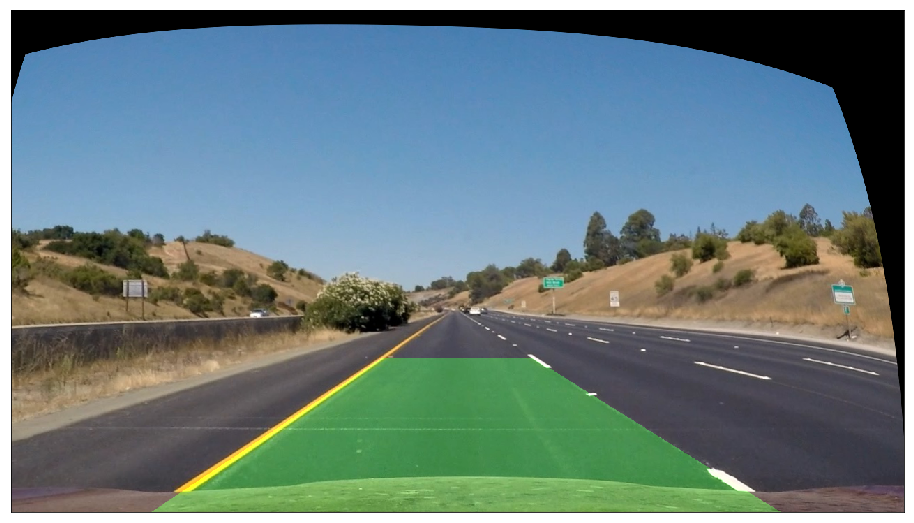

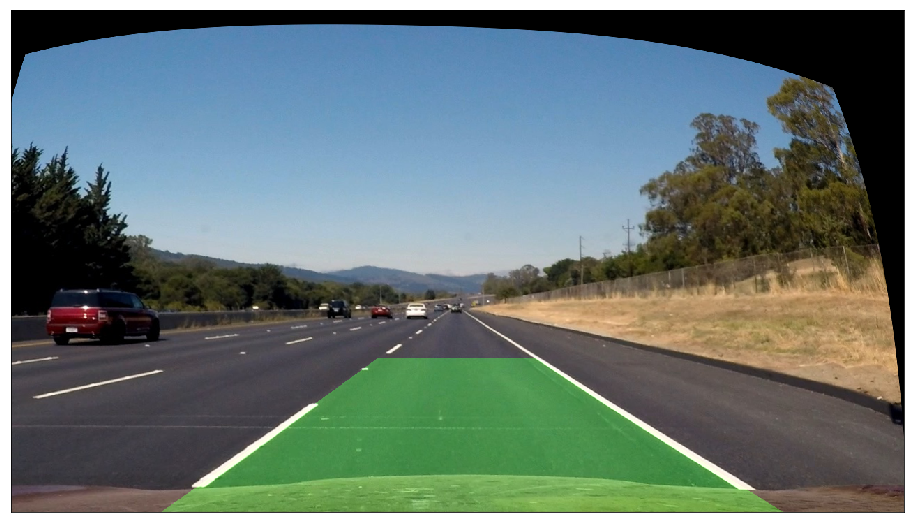

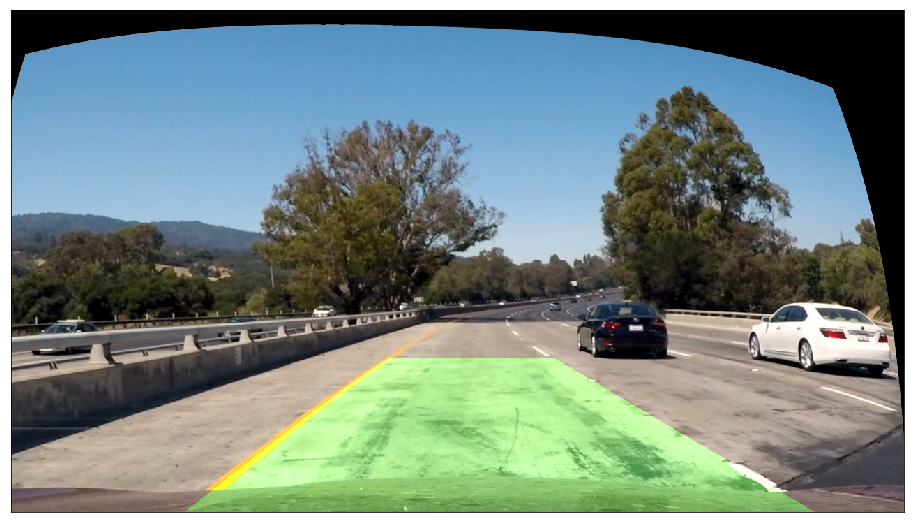

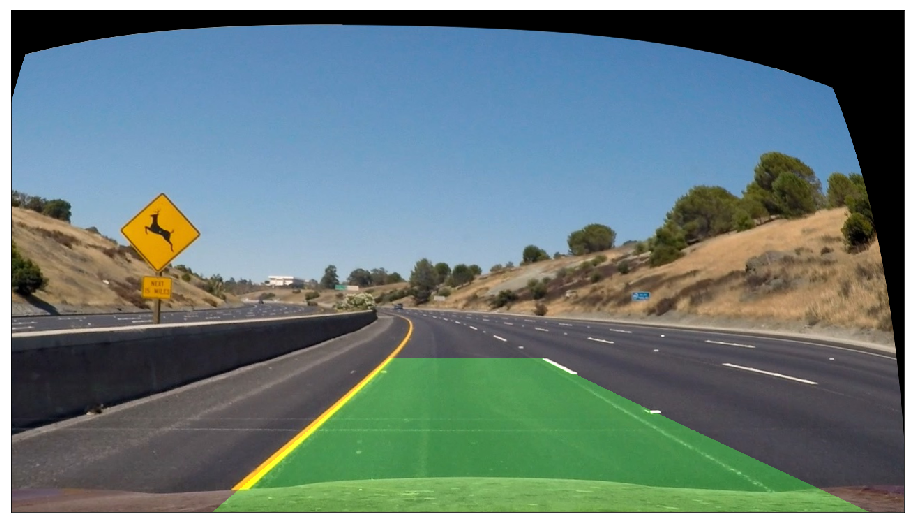

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [13]:
img_list =os.listdir("./test_images/")

for i in range (0, len(img_list)):
    left_line = Line()
    right_line = Line()
    big_pipeline(img_list[i])
    

In [14]:
def big_video_pipeline(image):
    
    #plt.figure(figsize=(16,16))
    #plt.imshow(image)
    #plt.plot(550, 450, 'x')
    #plt.plot(775, 450, 'x')
    #plt.plot(1100, 650, 'x')
    #plt.plot(225, 650, 'x')
    undist = cv2.undistort(image, mtx_avg, dist_avg, None, mtx_avg)

    corners = np.float32(
        [
            [550, 500],
            [775, 500],
            [1100, 720],
            [225, 720]               
         ])

    top_down, perspective_M = corners_unwarp(undist, corners)
    binary_warped_stacked = pipeline(top_down)

    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(image)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(top_down)
    #ax2.set_title('Undistorted and Warped Image', fontsize=50)
    #ax3.imshow(binary_warped_stacked)
    #ax3.set_title('+ Thresholding', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    binary_warped = binary_warped_stacked[:,:,0]

    # example from "Finding the lines" example
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.figure(figsize=(12,8))
    #plt.plot(histogram)

    left_fitx, right_fitx, lefty, righty, leftx, rightx, ploty, result = compute_lane_line_polynomials(top_down, binary_warped, undist)
    #plt.figure()
    #plt.imshow(result)

    replacement, Minv = corners_warp(result, corners)
    #plt.imshow(replacement)

    #calculate_lane_curvature(lefty, righty, leftx, rightx, ploty)

    # from "tips and tricks for the project"
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.figure(figsize=(16,16))
    #fig = plt.imshow(result)
    #fig.axes.get_xaxis().set_visible(False)
    #fig.axes.get_yaxis().set_visible(False)
    #plt.savefig('output_images/' + img_fname)    
    return result

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()

challenge_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(big_video_pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:34<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [17]:
print(len(right_line.allx))

3481038
